In [16]:
# start with importing the libraries we need
%matplotlib inline
import numpy as np
import brian2 as b2
import matplotlib.pyplot as plt

In [17]:
# Define all the parameters
tau_m=10*b2.ms
v_reset=-50*b2.mV
eta=0*b2.mV
v_rest=15*b2.mV
R=50*b2.ohm
beta=10e5*b2.Hz

# Exercise 0

1. Consider N = 100 non-interacting neurons, with initial voltages $v_i(t = 0)$ uniformly distributed at random between $v_0$ and $η$ (i.e. $v_i(0) ∼ U([v_0,η])$), and submitted to an oscillating external input $I_{ext}(t) = I_0(1 + sin(ωt))$, with $I_0 = 0.5 mA$, $ω = 10^2 s^{−1}(= 0.1 ms^{−1})$. <br>
• Compute the membrane potentials $v_i(t)$ and firing times of the neurons, for $t ≤ T_f = 100 ms$. <br>
• Plot the voltage $v_i(t)$ of the first neuron, along with the external input $RI_{ext}(t)$.

In [18]:
def oscillating_current(Tf : b2.ms, dt : b2.ms, I0 : b2.mA = 0.5*b2.mA, omega : b2.Hz = 100*b2.Hz):
    """create a TimedArray with an oscillating current

    Args:
        Tf (b2.ms): the final of the current simulation
        dt (b2.ms): the time interval between two time steps of the current
        I0 (b2.mA, optional): the max amplitude of the current. Defaults to 0.5*b2.mA.
        omega (b2.Hz, optional): the frequency of the current. Defaults to 100*b2.Hz.

    Returns:
        b2.TimedArray: the generated oscillating current
    """
    current = I0 * (1 + np.sin(omega * np.arange(0, Tf/b2.second, dt/b2.second)*b2.second))
    return b2.TimedArray(current, dt=dt)

In [19]:
def is_spike(v : b2.mV, dt : b2.ms, eta : b2.mV = eta, beta : b2.Hz = beta):
    """check if a spike occured at the current timestep given the potential of the neuron

    Args:
        v (b2.mV): the potential of the neuron at the current timestep
        dt (b2.ms): time interval between two timesteps
        eta (b2.mV, optional): the firing threshold of the neuron. Defaults to eta.
        beta (b2.Hz, optional): the firing rate of the neuron. Defaults to beta.

    Returns:
        bool: True if a spike occured, False otherwise
    """
    return v >= eta and beta*dt >= 0.5

def compute_potentials0(v_t0 : list, I_ext : b2.TimedArray, Tf : b2.ms, dt : b2.ms, v_rest : b2.mV = v_rest, v_reset : b2.mV = v_reset, R : b2.ohm = R, tau_m : b2.ms = tau_m):
    """compute the evolution of the potential for the neuron population given an external current and compute the spikes

    Args:
        v_t0 (list): initial potential of the neurons
        I_ext (b2.TimedArray): external current applied to the neuron
        Tf (b2.ms): final time of the simulation
        dt (b2.ms): time interval between two timesteps
        v_rest (b2.mV, optional): the resting potential of the neuron. Defaults to v_rest.
        v_reset (b2.mV, optional): the reset potential of the neuron after a spike. Defaults to v_reset.
        R (b2.ohm, optional): the resistance of the neuron. Defaults to R.
        tau_m (b2.ms, optional): the membrane time constant of the neuron. Defaults to tau_m.

    Returns:
        list, list: the potential of the neuron at each timestep (tk) and the spiking activity of the neuron at each step (k)
    """
    N = len(v_t0)
    potentials = [v_t0]
    spikes = [np.zeros(N)]
    
    v = v_t0
    for k in range(int(Tf / dt)):
        s = []
        for neuron in range(N):
            v[neuron] = v[neuron] + dt * (v_rest - v[neuron] + R * I_ext(k*dt)) / tau_m
            s.append(is_spike(v[neuron], dt))
            if s[neuron]:
                v[neuron] = v_reset
        potentials = potentials + [v]
        spikes = spikes + [s]
    return np.array(potentials), np.array(spikes)

In [20]:
# Define the current, the initial potential and other parameters
Tf = 100*b2.ms
dt = 0.01*b2.ms
input_current = oscillating_current(Tf, dt)
N=100
np.random.seed(12)
v_t0 = np.random.uniform(v_reset, eta, N) * b2.volt

In [21]:
# Compute the potentials and spikes
potentials0, spikes0 = compute_potentials0(v_t0, input_current, Tf, dt)

In [ ]:
# Plot the voltage of the first neuron and the external input RIext(t)
plt.plot(np.arange(len(potentials0[:,0]))*dt/b2.ms, potentials0[0]/b2.mV, label='Voltage of the first neuron')
plt.plot(np.arange(len(input_current.values))*input_current.dt/b2.ms, R*input_current.values/b2.mV, label='External input R*Iext(t)')
plt.title('Voltage of the first neuron and of the external input R*Iext(t)')
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (mV)')
plt.legend()
plt.show()

TypeError: list indices must be integers or slices, not tuple

2. Plot the low-pass filtered activity of the population, using a time bin of τA = 1ms. Make the corresponding raster plot

In [ ]:
def low_pass_filtering(activity : list, dt : b2.ms, tau_A : b2.ms = 1*b2.ms):
    """apply a low-pass filter to the activity of a neuron

    Args:
        activity (b2.TimedArray): the activity of the neuron
        dt (b2.ms): time interval between two timesteps
        tau_A (b2.ms, optional): the width of the time bin. 

    Returns:
        list: the filtered activity
    """
    tau_A = int(tau_A / dt) + 1 # convert time into #timestep, add 1 to include the timestep t=0
    return np.convolve(activity, np.ones(tau_A)/tau_A, mode='same')

def network_activity(spikes : list, dt : b2.ms):
    """compute the network activity of a population of neurons

    Args:
        spikes (list): the spiking activity of each neuron
        dt (b2.ms): time interval between two timesteps

    Returns:
        list: the network activity of the population for each timestep
    """
    return np.sum(spikes0, axis=1) / len(spikes[0]) / (dt/b2.second)

In [ ]:
def activity_plot(activity : list, dt : b2.ms):
    """plot the network activity of a population of neurons

    Args:
        activity (list): the spiking activity of each neuron
        dt (b2.ms): time interval between two timesteps
    """
    plt.figure(figsize=(10, 5))
    plt.plot(np.arange(len(activity))*dt/b2.ms, activity)
    plt.title('Network activity A(t)')
    plt.xlabel('Time (ms)')
    plt.ylabel('Activity (Hz)')
    plt.show()
    
def compute_spiking_times(spikes : list, dt : b2.ms):
    """compute the spiking times of a population of neurons

    Args:
        spikes (list): the spiking activity of each neuron
        dt (b2.ms): dt of the simulation

    Returns:
        list: the spiking times of each neuron
    """
    spiking_times = []
    for neuron in range(len(spikes[0])):
        spiking_times.append(np.where(spikes[:, neuron])[0] * dt / b2.ms)
    return spiking_times
    
def raster_plot(spiking_times : list, dt : b2.ms, start_time : b2.ms = 0*b2.ms, end_time : b2.ms = Tf, title : str = 'Raster plot of the spikes of the neurons'):
    """plot the raster plot of a population of neurons

    Args:
        spiking_times (list): the spiking times of each neuron
        dt (b2.ms): dt of the simulation
        start_time (b2.ms, optional): the time at which the raster plot starts. Defaults to 0*b2.ms.
        end_time (b2.ms, optional): the time at which the raster plot ends. Defaults to Tf.
        title (str, optional): the title of the plot. Defaults to 'Raster plot of the spikes of the neurons'.
        
    Returns:
        list: the spiking times of each neuron
    """
    
    start_time = int(start_time / dt)
    end_time = int(end_time / dt)
    plt.figure(figsize=(10, 5))
    for neuron in range(len(spiking_times)):
        plt.scatter(spiking_times[neuron], neuron*np.ones(len(spiking_times[neuron])), color='black')
    plt.title(title)
    plt.xlim(start_time*dt/b2.ms, end_time*dt/b2.ms)
    plt.xlabel('Time (ms)')
    plt.ylabel('Neuron #')
    plt.show()

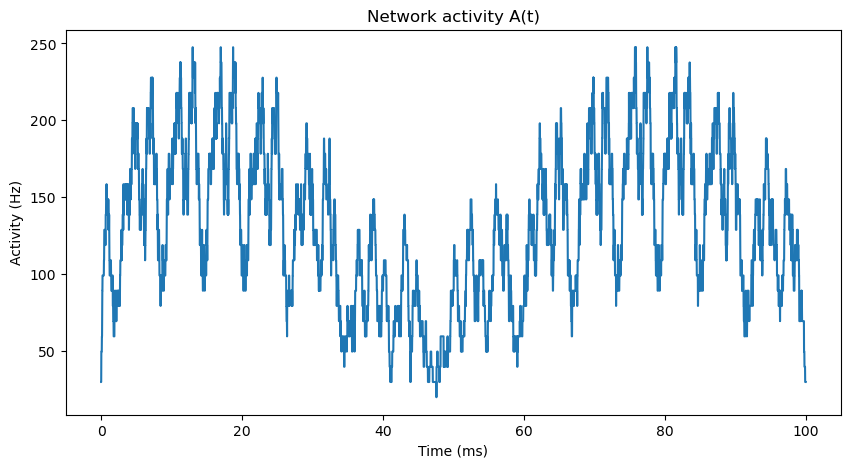

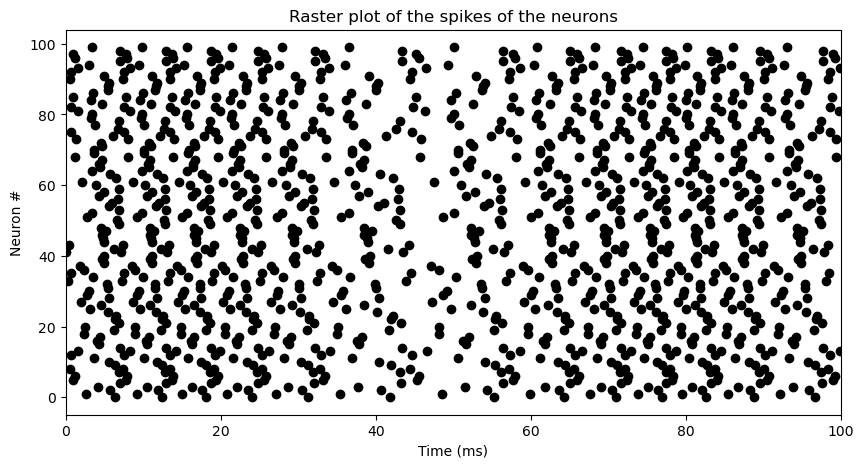

In [ ]:
activity0 = low_pass_filtering(network_activity(spikes0, dt), dt)
activity_plot(activity0, dt)
raster_plot(compute_spiking_times(spikes0, dt), dt)

# Exercise 1

In [ ]:
# Define the parameters
delta = 5*b2.ms
tau_epsilon = 2*b2.ms
J = 20*b2.mV

Tf=600*b2.ms
dt=0.1*b2.ms

input_current = np.zeros(int(Tf/dt)+1)*b2.mA
N=100
np.random.seed(24)
v_t0 = np.random.uniform(v_reset, eta, N) * b2.volt
epsilonA_0 = 0*b2.Hz
epsilonB_0 = 0*b2.Hz

### Implementation of the interaction

In [ ]:
def next_epsilon(eA_prev : b2.Hz, eB_prev : b2.Hz, spikes_prev : np.array, dt : b2.ms, tau_epsilon : b2.ms = tau_epsilon):
    """compute the next value of epsilonA and epsilonB

    Args:
        eA_prev (b2.Hz): previous value of epsilonA
        eB_prev (b2.Hz): previous value of epsilonB
        spikes_prev (np.array): array of the spikes of the neurons at the previous timestep
        dt (b2.ms): timestep of the simulation
        tau_epsilon (b2.ms, optional): rise time of the kernel function. Defaults to tau_epsilon.

    Returns:
        float, float: the next values of epsilonA and epsilonB
    """
    epsilonA = eA_prev + (-eA_prev + eB_prev) * (dt/tau_epsilon)
    epsilonB = eB_prev + (-eB_prev * dt + np.sum(spikes_prev)/len(spikes0)) / tau_epsilon 
    return epsilonA, epsilonB

def population_potential_spikes(v_prev : np.array, epsilonA : b2.Hz, dt : b2.ms, I_ext : b2.mA, v_rest : b2.mV = v_rest, R : b2.ohm = R, tau_m : b2.ms = tau_m, J : b2.mV = J, v_reset : b2.mV = v_reset):
    """compute the membrane potential and the spikes of a population of neurons at the next timestep

    Args:
        v_prev (np.array): array of the membrane potentials of the neurons at the previous timestep
        epsilonA (b2.Hz): value of epsilonA at the previous timestep
        dt (b2.ms): timestep of the simulation
        I_ext (b2.mA): external current applied to the neurons
        v_rest (b2.mV, optional): membrane potential at rest. Defaults to v_rest.
        R (b2.ohm, optional): membrane resistance. Defaults to R.
        tau_m (b2.ms, optional): membrane time constant. Defaults to tau_m.
        J (b2.mV, optional): the interaction strength. Defaults to J.
        v_reset (b2.mV, optional): the reset potential (after a spike). Defaults to v_reset.

    Returns:
        np.array, np.array: the membrane potentials and the spikes of the neurons at the next timestep
    """
    potentials, spikes = [], []
    for neuron in range(N):
        v_next = v_prev[neuron] - (dt/tau_m) * (v_prev[neuron] - v_rest - R*I_ext) + dt * J * epsilonA
        spikes.append(is_spike(v_next, dt))
        if spikes[-1]:
            v_next = v_reset
        potentials.append(v_next)
    return potentials, spikes


def compute_potentials1(v_t0 : np.array, epsilonA_0 : b2.Hz, epsilonB_0 : b2.Hz, Tf : b2.ms, dt : b2.ms, v_rest : b2.mV = v_rest, I_ext : np.array = input_current, R : b2.ohm = R, tau_m : b2.ms = tau_m, J : b2.mV = J, v_reset : b2.mV = v_reset):
    """compute the potentials and the spikes of the neurons in a self-interacting population

    Args:
        v_t0 (np.array): initial potentials of the neurons
        epsilonA_0 (b2.Hz): initial value of epsilonA
        epsilonB_0 (b2.Hz): initial value of epsilonB
        Tf (b2.ms): end time of the simulation
        dt (b2.ms): timestep of the simulation
        v_rest (b2.mV, optional): the resting potential of the neurons. Defaults to v_rest.
        I_ext (np.array, optional): the external input current. Defaults to input_current.
        R (b2.ohm, optional): the membrane resistance. Defaults to R.
        tau_m (b2.ms, optional): the membrane time constant. Defaults to tau_m.
        J (b2.mV, optional): the interaction strength. Defaults to J.
        v_reset (b2.mV, optional): the reset potential. Defaults to v_reset.

    Returns:
        list, list: the potentials and the spikes of the neurons
    """
    potentials = [v_t0]
    spikes = [[0] * len(v_t0)]
    epsilonA = [epsilonA_0] * int(delta/dt)
    e_B = epsilonB_0
    
    for k in range(1, int(Tf/dt) + 1):
        # Compute the next epsilonA and epsilonB
        e_A, e_B = next_epsilon(epsilonA[-1], e_B, spikes[-1], dt)
        epsilonA.append(e_A)
        
        # Compute the next potential for each neuron
        v_next, spikes_next = population_potential_spikes(potentials[-1], epsilonA[-1], dt, I_ext[k], v_rest, R, tau_m, J, v_reset)
        potentials = potentials + [v_next]
        spikes = np.vstack((spikes, spikes_next))
    return potentials, spikes

### Spontaneous dynamics of the system

In [ ]:
potentials1, spikes1 = compute_potentials1(v_t0, epsilonA_0, epsilonB_0, Tf, dt)

In [ ]:
activity1 = low_pass_filtering(network_activity(spikes1, dt), tau_A=0.5*b2.ms)
activity_plot(activity1)
spiking_times1 = compute_spiking_times(spikes1, dt)
raster_plot(spiking_times1, dt, end_time=200*b2.ms, title="Raster plot of the 200 first ms of the simulation of the self-interacting population")
raster_plot(spiking_times1, dt, start_time=Tf-200*b2.ms, title="Raster plot of the 30 last ms of the simulation of the self-interacting population")

TypeError: network_activity() takes 2 positional arguments but 3 were given

In [ ]:
from scipy.signal import find_peaks

# Extract peaks of the activity
peaks_indices, _ = find_peaks(spiking_times1[0], height=0.5, )


for neuron in len(spiking_times1):
    print("Period between two spikes of neuron {} : {} ms".format(neuron, spiking_times1[neuron][1] - spiking_times1[neuron][0]))